# Task 2 - Time Series
Define, train, and test an ML model (preferably a neural network) to recognize the activity being performed in the following human activity recognition dataset: https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones

## Labels
['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS']

In [1]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import torch.nn as nn
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display



### Helper Functions

In [7]:
def get_path(task_number, *args):
    notebook_path = os.path.abspath(f"Task_{task_number}.ipynb")
    return os.path.join(os.path.dirname(notebook_path), *args)

def preprocess_data(df, column="Activity"):
    le = LabelEncoder()
    scaler = StandardScaler()

    # Encode the activity column
    encoded_labels = le.fit_transform(df[column])
    
    # Drop the specified column and "subject" column
    df = df.drop(column, axis=1).drop("subject", axis=1)

    # Normalize the DataFrame
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    return df_normalized, encoded_labels

### Load The Data Into Pandas


In [8]:
MODEL_PATH = get_path(2, "model", "activity_loc_rnn.pt")

train_data = pd.read_csv(get_path(2, "data", "train.csv"))
test_data = pd.read_csv(get_path(2, "data", "test.csv"))

# Split into label and features
train_data, train_labels = preprocess_data(train_data)
test_data, test_labels = preprocess_data(test_data)

train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.200642,-0.063683,-0.419628,-0.868814,-0.939441,-0.737529,-0.859817,-0.939019,-0.766437,-0.856036,...,-0.795359,0.025960,-0.276399,-0.360603,0.062940,-0.778427,-0.026080,-0.687219,0.407946,-0.007568
1,0.055948,0.031486,-0.253908,-0.875426,-0.923902,-0.849304,-0.868531,-0.921998,-0.848928,-0.871359,...,0.130614,-0.897357,-0.767990,0.133011,-0.021461,-1.218805,1.484470,-0.694138,0.409117,0.007875
2,0.073515,-0.043416,-0.076295,-0.869039,-0.907760,-0.893785,-0.863137,-0.898854,-0.896701,-0.863323,...,1.152336,-0.260878,-0.438316,-0.377840,0.391976,0.151207,1.704201,-0.702239,0.410288,0.026502
3,0.066696,-0.208422,-0.249712,-0.870626,-0.940022,-0.921805,-0.864503,-0.938124,-0.925279,-0.863323,...,1.112769,0.591045,0.463155,-0.135025,-0.033637,1.037851,-1.003019,-0.701684,0.414650,0.031714
4,0.030469,0.027587,-0.109848,-0.875188,-0.934878,-0.921343,-0.867384,-0.931789,-0.928028,-0.870260,...,-0.149577,-0.138515,-0.240313,0.340406,0.268486,1.125918,-1.276282,-0.700152,0.425463,0.045225


# SVM Solution

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='linear')

# Train
clf.fit(train_data, train_labels)

# Predict
y_pred = clf.predict(test_data)

# Model Accuracy
print(f"Accuracy: {100*accuracy_score(test_labels, y_pred):.4}%")



Accuracy: 96.2%


# Neural Network Solution

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#lstm

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y, seq_length):
        self.X = X
        self.Y = Y
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        data = np.array(self.X.values[idx*self.seq_length : (idx+1)*self.seq_length], dtype=np.float32).reshape(self.seq_length, -1)
        target = np.array(self.Y[(idx+1)*self.seq_length-1], dtype=np.float32)
        
        return data, target


class NeuralNetTask2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(NeuralNetTask2, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        x: (sequence_length: L, batch_size: N, input_size: H_in) (batchfirst=false)
        """
        
        # (num_layers, batch_size: N, hidden_size: H_out=H_cell)
        h_0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        
        out, _ = self.lstm(x, (h_0, c_0))
        out = out[-1, :, :].reshape(-1, self.hidden_size)
        out = self.fc(out)
        
        return out
    
    
# Hyperparameters
batch_size = 16
sequence_length = 64
input_size = 561
hidden_size = 64
num_layers = 1
num_classes = 6

lr = 10e-3
num_epochs = 100
save_steps = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_dataset = TimeSeriesDataset(train_data, train_labels, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TimeSeriesDataset(test_data, test_labels, sequence_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = NeuralNetTask2(input_size, hidden_size, num_layers, num_classes)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

### Train The Model

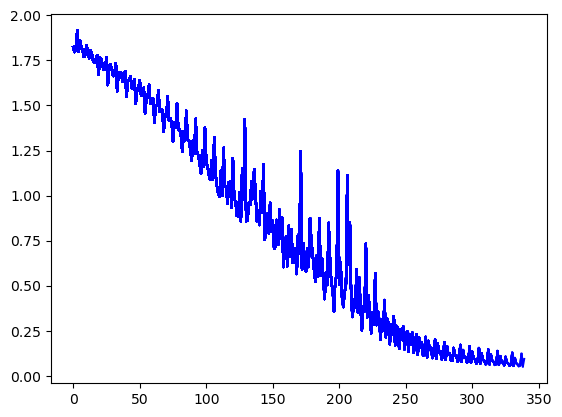

Epoch [50/100], Step [3/7], Loss: 0.0668


In [7]:
losses = []

# Iterate through number of epochs and determine next step
for epoch in range(num_epochs):
    try:
        for i, (inputs, labels) in enumerate(train_loader):
            
            # (sequence_length: L, batch_size: N, input_size: H_in)
            inputs = inputs.to(device)
            inputs = inputs.reshape(sequence_length, batch_size, input_size)
            target = labels.to(device)
                    
            # outputs: (sequence_length: L, batch_size: N, hidden_size: H_out)
            outputs = model(inputs.float())
            
            loss = criterion(outputs, target.long())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # print loss
            print (f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{train_data.shape[0]//(batch_size*sequence_length)}], Loss: {loss:.4f}")
            
            # Plot the loss
            losses.append(loss.item())
            pl.plot(losses, 'b')
            display.clear_output(wait=True)
            display.display(pl.gcf())
        
        # Save the model here, in case of interruption or if I'm bored cause my cpu too slow  
        # Save every [save_steps] steps
        torch.save(model.state_dict(), MODEL_PATH)
        print("Model saved at", MODEL_PATH)
        
    except:
        print("No Data Left")
        continue
    

print("Training finished")

### Load the Model


In [10]:
model = NeuralNetTask2(input_size, hidden_size, num_layers, num_classes)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

NeuralNetTask2(
  (lstm): LSTM(561, 64)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

### Test The Model

In [12]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    
    try:
        for i, (inputs, labels) in enumerate(train_loader):
                
            inputs = inputs.reshape(sequence_length, batch_size, input_size)
            target = labels.to(device)
                        
            outputs = model(inputs.float())            
            _, predicted = torch.max(outputs.data, 1)
            
            #print("Model Output: ", outputs)
            #print("Target: ", target)
            #print("Predicted: ", predicted)
            
            total += labels.size(0)
            correct += (predicted == target).sum().item()
            print(f"Accuracy: {(100 * correct / total):.4}%")

    except:
        print("No Data Left")
        pass

        

Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
No Data Left
